https://towardsdatascience.com/calculating-sample-size-using-vc-dimensions-a-machine-learning-way-748abbe1b1e4

https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html

In [44]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from skimage.transform import resize
from statsmodels.stats.proportion import proportion_confint

# not enough GPU memory on personal device, so turn off GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

### Get filenames

In [2]:
filenames = []
N = 150 # samples per class
for folder_num in np.arange(0,10):
    mydir = 'imgs/train/c'+ str(folder_num)
    ims = 0
    for file in os.listdir(mydir):
        if (file.endswith(".jpg")) and (ims <= N):
            filenames.append(file)
            ims+=1

### Load, Scale, and Split data

In [3]:
# Loading Data
X = np.load('data_small.npy')
Y = np.load('labels_small.npy')

In [4]:
X = X/255.

In [5]:
# Training and Test sets
X_training, X_test, y_training, y_test = train_test_split(X.T, 
                                                  Y, 
                                                  shuffle=True,
                                                  stratify=Y,
                                                  test_size=0.15,
                                                  random_state=42)

# Training and Test sets
X_training, X_test, train_filenames, test_filenames = train_test_split(X.T, 
                                                  np.asarray(filenames), 
                                                  shuffle=True,
                                                  stratify=Y,
                                                  test_size=0.15,
                                                  random_state=42)

In [6]:
del X, Y

### Resize images, create tf tensors

In [14]:
# initialize array for compressed images to be stored
data_resized = np.empty((len(y_training),(67500)))

for img_idx in range(len(y_training)):
    im = X_training[img_idx].reshape(300,300,3) 
    data_resized[img_idx] = resize(im, (150,150, 3)).flatten() 

# Train/Learn and validation sets
X_train, X_val, t_train, t_val = train_test_split(data_resized, 
                                                  y_training, 
                                                  shuffle=True,
                                                  stratify=y_training,
                                                  test_size=0.2,
                                                  random_state=42)

# cast numpy arrays into tensorflow tensors
X_train_rs = tf.constant(X_train.reshape((X_train.shape[0],150,150,3)),
                        dtype=tf.float16)

X_val_rs = tf.constant(X_val.reshape((X_val.shape[0],150,150,3)),
                        dtype=tf.float16)

data_resized = np.empty((len(X_test),(67500)))


### test set ###
for img_idx in range(len(X_test)):
    im = X_test[img_idx].reshape(300,300,3) 
    data_resized[img_idx] = resize(im, (150,150, 3)).flatten() 


X_test_rs = tf.constant(data_resized.reshape((data_resized.shape[0],150,150,3)),
                        dtype=tf.float16)


In [15]:
del data_resized, X_training, y_training

### Create Model

In [16]:
# augment data - apply random rotation 
IMG_SIZE = 150 # define fixed image size
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomRotation(0.125, seed = 42)
])

    # Create CNN  
model = tf.keras.Sequential([
        data_augmentation,

    keras.applications.Xception(
    weights='imagenet',  
    input_shape=(150, 150, 3),
    include_top=False) ,
    
    Conv2D(32, 5, activation='relu', padding='same'),
    MaxPooling2D(2),

    Conv2D(64, 5, activation='relu', padding='same'),
    Conv2D(64, 5, activation='relu', padding='same'),
    MaxPooling2D(2),
    Flatten(),

    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.25),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
                 optimizer=keras.optimizers.Adam(0.0005),
                 metrics=[tf.keras.metrics.Recall(), 
                          tf.keras.metrics.Precision()])

### Train model

In [17]:
# train model
history = model.fit(X_train_rs, t_train, epochs=100, batch_size=64,
             validation_data=(X_val_rs, t_val),
             callbacks=[keras.callbacks.EarlyStopping(patience=20),
                           keras.callbacks.ModelCheckpoint('final_model.h5', 
                                                           save_best_only=True)])


Epoch 1/100
17/17 [==============================] - 98s 5s/step - loss: 0.3195 - recall: 0.9437 - precision: 0.9008 - val_loss: 0.3961 - val_recall: 1.0000 - val_precision: 0.8988
Epoch 2/100
17/17 [==============================] - 84s 5s/step - loss: 0.1925 - recall: 1.0000 - precision: 0.9006 - val_loss: 0.5324 - val_recall: 1.0000 - val_precision: 0.8988
Epoch 3/100
17/17 [==============================] - 83s 5s/step - loss: 0.1746 - recall: 1.0000 - precision: 0.9006 - val_loss: 0.6011 - val_recall: 1.0000 - val_precision: 0.8988
Epoch 4/100
17/17 [==============================] - 82s 5s/step - loss: 0.1583 - recall: 0.9935 - precision: 0.9320 - val_loss: 0.6009 - val_recall: 1.0000 - val_precision: 0.8988
Epoch 5/100
17/17 [==============================] - 82s 5s/step - loss: 0.1320 - recall: 0.9719 - precision: 0.9740 - val_loss: 0.5350 - val_recall: 1.0000 - val_precision: 0.8988
Epoch 6/100
17/17 [==============================] - 84s 5s/step - loss: 0.1462 - recall: 0.983

17/17 [==============================] - 88s 5s/step - loss: 0.0276 - recall: 0.9935 - precision: 0.9978 - val_loss: 0.1138 - val_recall: 0.9827 - val_precision: 0.9913
Epoch 47/100
17/17 [==============================] - 88s 5s/step - loss: 0.0197 - recall: 0.9978 - precision: 0.9903 - val_loss: 0.1479 - val_recall: 0.9697 - val_precision: 0.9956
Epoch 48/100
17/17 [==============================] - 87s 5s/step - loss: 0.0368 - recall: 0.9946 - precision: 0.9924 - val_loss: 0.1926 - val_recall: 0.9740 - val_precision: 0.9868
Epoch 49/100
17/17 [==============================] - 85s 5s/step - loss: 0.0471 - recall: 0.9816 - precision: 0.9967 - val_loss: 0.2560 - val_recall: 1.0000 - val_precision: 0.9665
Epoch 50/100
17/17 [==============================] - 86s 5s/step - loss: 0.0275 - recall: 0.9989 - precision: 0.9957 - val_loss: 0.3749 - val_recall: 1.0000 - val_precision: 0.9467
Epoch 51/100
17/17 [==============================] - 86s 5s/step - loss: 0.0099 - recall: 0.9989 - pre

### Load model, obtain conf matrix, determine wald int of false positives

In [13]:
# model = tf.keras.models.load_model('final_Xception_model.h5')

In [18]:
y_train_pred = model.predict(X_train_rs)

33/33 [==============================] - 17s 479ms/step


In [19]:
y_val_pred = model.predict(X_val_rs)

9/9 [==============================] - 4s 438ms/step


Distracted driver == 0, meaning they are considered a negative. Not distracted == 1, meaning they are considered posiitve. We do not want to to falsely label a negative as a positive; hence, we want to minimize false positives. 

In [26]:
# def f1_and_BPCI(X, y, model):
def f1_and_BPCI(y, y_pred):
    
#     # resize input X
#     data_resized = np.empty((len(y),(67500)))

#     for img_idx in range(len(y)):
#         im = X[img_idx].reshape(300,300,3) 
#         data_resized[img_idx] = resize(im, (150,150, 3)).flatten() 

#     # cast numpy arrays into tensorflow tensors
#     X_rs = tf.constant(data_resized.reshape((data_resized.shape[0],150,150,3)),
#                             dtype=tf.float32)
    
#     # test on resized X
#     y_pred = np.round(model.predict(X_rs))
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    count = (fp)
    nobs = sum((fp, tp))
    lb, ub = proportion_confint(count, nobs, alpha = 0.05, method = 'beta')
    f1 = f1_score(y, y_pred)
    
    print('F1-score: ', "{:.2f}".format(f1), '\nWe are 95% confident that the true proportion of false positive predictions falls between ', 
          "{:.2f}".format(lb*100),'%', ' and ', "{:.2f}".format(ub*100),'%')
    return

In [24]:
# testing
print('TRAINING RESULTS')
f1_and_BPCI(np.round(y_train_pred), t_train)

TRAINING RESULTS
F1-score:  1.00 
We are 95% confident that the true proportion of false positive predictions falls between  0.0 %  and  0.4 %


In [27]:
# training
print('VALIDATION RESULTS')
f1_and_BPCI(np.round(y_val_pred), t_val)

VALIDATION RESULTS
F1-score:  0.99 
We are 95% confident that the true proportion of false positive predictions falls between  0.00 %  and  1.58 %


### Learning curves

In [30]:
import matplotlib.pyplot as plt

In [33]:
history.history.keys()

dict_keys(['loss', 'recall', 'precision', 'val_loss', 'val_recall', 'val_precision'])

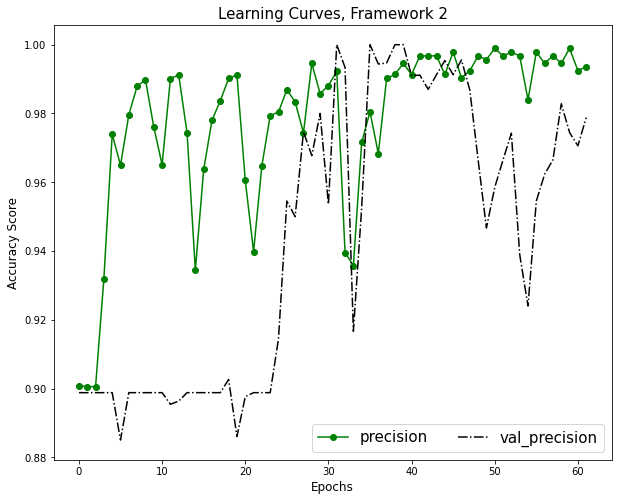

In [43]:
key_names = list(('precision',  'val_precision'))
# key_names = list(('loss', 'val_loss'))
colors = ['-og','-.k', 'r', 'b', '--m', '-oy'] 
font = {'size'   : 12}

plt.figure(figsize=(10,8))
for i in range(len(key_names)):
    plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])

# plt.plot(normalized_loss, colors[2], label='Normalized loss')
# plt.plot(normalized_val_loss, colors[3], label='Normalized validation loss')
plt.legend(fontsize=15,ncol=2)
plt.ylabel('Accuracy Score', **font)
plt.xlabel('Epochs', **font)
plt.title('Learning Curves, Framework 2', size=15);

### BPCI Robustness

In [85]:
def f1_and_BPCI(X, y, model):
    
    # cast numpy arrays into tensorflow tensors
    X_rs = tf.constant(X.reshape((X.shape[0],150,150,3)),
                            dtype=tf.float32)
#     X_rs = X
    # test on resized X
    y_pred = np.round(model.predict(X_rs))
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    count = (fp)
    nobs = sum((fp, tp))
    lb, ub = proportion_confint(count, nobs, alpha = 0.05, method = 'beta')
    f1 = f1_score(y, y_pred)
    
    print('F1-score: ', "{:.2f}".format(f1), '\nWe are 95% confident that the true proportion of false positive predictions falls between ', 
          "{:.2f}".format(lb*100),'%', ' and ', "{:.2f}".format(ub*100),'%')
    return

In [86]:
f1_and_BPCI(X_test_rs, y_test, model)

8/8 [==============================] - 4s 454ms/step
F1-score:  0.98 
We are 95% confident that the true proportion of false positive predictions falls between  1.34 %  and  6.72 %
